Question 2

Training GRU model...
5000 5.00% (0m 28s) 2.8881 Medeiros -> Spanish ✗ (Portuguese)
10000 10.00% (0m 58s) 2.6746 Shammas -> Greek ✗ (Arabic)
15000 15.00% (1m 33s) 2.1742 Marchioni -> Italian ✓
20000 20.00% (2m 6s) 1.7879 Byon -> Vietnamese ✗ (Korean)
25000 25.00% (2m 31s) 2.1762 Baz -> Vietnamese ✗ (Arabic)
30000 30.00% (2m 58s) 0.4102 Valentini -> Italian ✓
35000 35.00% (3m 23s) 0.9474 Ziemniak -> Polish ✓
40000 40.00% (3m 48s) 1.6896 Mcmillan -> Irish ✗ (Scottish)
45000 45.00% (4m 13s) 2.1258 Johnstone -> French ✗ (Scottish)
50000 50.00% (4m 38s) 0.1146 Komatsuzaki -> Japanese ✓
55000 55.00% (5m 3s) 3.5856 Prehatney -> Irish ✗ (Czech)
60000 60.00% (5m 28s) 0.7024 Bui -> Chinese ✓
65000 65.00% (5m 54s) 0.0291 Eliopoulos -> Greek ✓
70000 70.00% (6m 20s) 1.9002 Eda -> Czech ✗ (Japanese)
75000 75.00% (6m 45s) 1.2623 Crespo -> Italian ✗ (Spanish)
80000 80.00% (7m 10s) 2.8345 Entler -> German ✗ (Czech)
85000 85.00% (8m 0s) 3.0306 Aitken -> Dutch ✗ (Scottish)
90000 90.00% (8m 47s) 2.0971 En

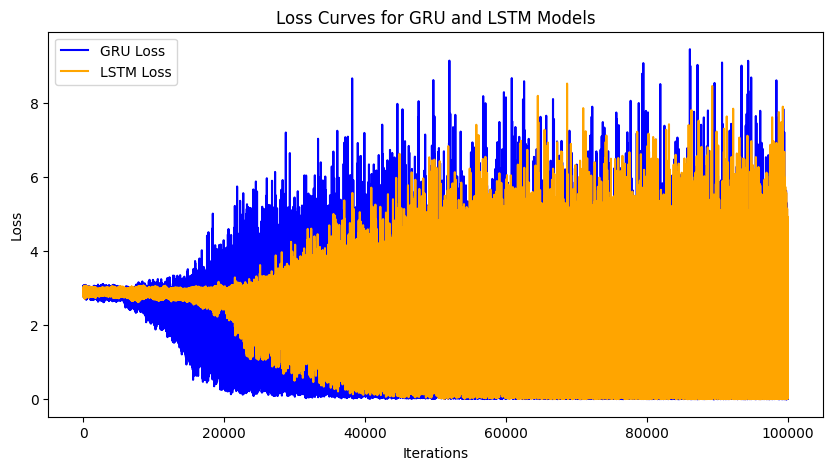

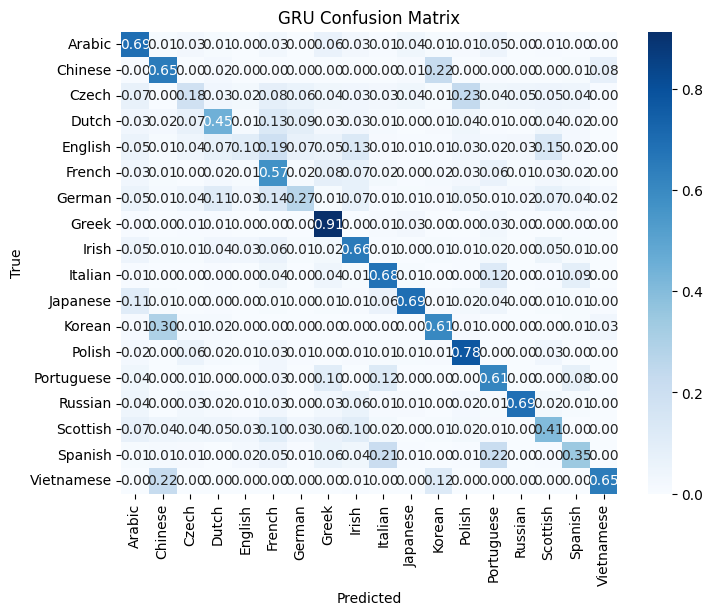

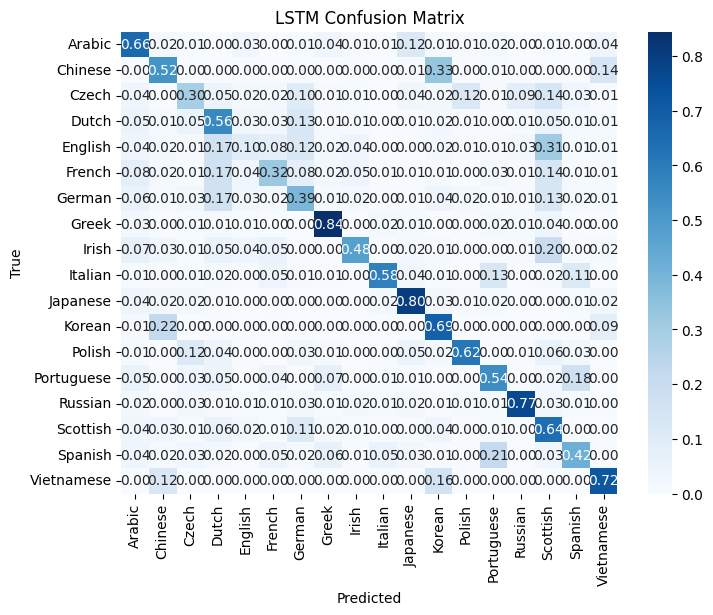


> Dovesky
Russian (0.72)
Czech (0.17)
Polish (0.06)

> Dovesky
Russian (0.64)
Czech (0.15)
Polish (0.06)

> Jackson
Scottish (0.68)
English (0.11)
Polish (0.07)

> Jackson
Scottish (0.70)
English (0.12)
Dutch (0.06)

> Satoshi
Arabic (0.65)
Japanese (0.27)
Polish (0.03)

> Satoshi
Japanese (0.73)
Arabic (0.23)
Italian (0.01)


In [ ]:
import os
import glob
import string
import unicodedata
import torch
import torch.nn as nn
import random
import time
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.ticker as ticker


def get_files(path):
    return glob.glob(path)

def normalize_string(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn' and c in string.ascii_letters + " .,;'"
    )

def load_data():
    categories, data = [], {}
    for filepath in get_files('data/names/*.txt'):
        category_name = os.path.splitext(os.path.basename(filepath))[0]
        categories.append(category_name)
        with open(filepath, encoding='utf-8') as file:
            data[category_name] = [normalize_string(line) for line in file.read().splitlines()]
    return categories, data

all_categories, category_lines = load_data()
n_categories = len(all_categories)


def char_to_tensor(char):
    tensor = torch.zeros(len(string.ascii_letters + " .,;'"))
    tensor[string.ascii_letters.find(char)] = 1
    return tensor

def word_to_tensor(word):
    tensor = torch.zeros(len(word), len(string.ascii_letters + " .,;'"))
    for idx, char in enumerate(word):
        tensor[idx] = char_to_tensor(char)
    return tensor

def random_example():
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)])
    line_tensor = word_to_tensor(line)
    return category, line, category_tensor, line_tensor


class GRUClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_tensor, hidden):
        output, hidden = self.gru(input_tensor.unsqueeze(1), hidden)
        output = self.fc(output[-1])
        return self.log_softmax(output), hidden

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size)

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_tensor, hidden):
        output, hidden = self.lstm(input_tensor.unsqueeze(1), hidden)
        output = self.fc(output[-1])
        return self.log_softmax(output), hidden

    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_size),
                torch.zeros(1, 1, self.hidden_size))


def train_step(model, category_tensor, line_tensor, optimizer, criterion):
    model.zero_grad()
    hidden = model.init_hidden()
    for char_tensor in line_tensor:
        output, hidden = model(char_tensor.unsqueeze(0), hidden)
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()
    return output, loss.item()

def train_model(model, n_iters, print_every=5000):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.005)
    criterion = nn.NLLLoss()
    start = time.time()
    losses = []

    for iteration in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = random_example()
        output, loss = train_step(model, category_tensor, line_tensor, optimizer, criterion)
        losses.append(loss)

        if iteration % print_every == 0:
            guess = category_from_output(output)
            correct = "✓" if guess == category else f"✗ ({category})"
            print(f"{iteration} {iteration / n_iters:.2%} ({time_since(start)}) {loss:.4f} {line} -> {guess} {correct}")

    return losses

def category_from_output(output):
    _, top_index = output.topk(1)
    return all_categories[top_index.item()]

def time_since(since):
    now = time.time()
    elapsed = now - since
    return f"{int(elapsed // 60)}m {int(elapsed % 60)}s"


n_hidden = 128
n_letters = len(string.ascii_letters + " .,;'")
gru_model = GRUClassifier(n_letters, n_hidden, n_categories)
lstm_model = LSTMClassifier(n_letters, n_hidden, n_categories)


print("Training GRU model...")
gru_losses = train_model(gru_model, 100000, 5000)


print("Training LSTM model...")
lstm_losses = train_model(lstm_model, 100000, 5000)


plt.figure(figsize=(10, 5))
plt.plot(gru_losses, label="GRU Loss", color='blue')
plt.plot(lstm_losses, label="LSTM Loss", color='orange')
plt.title("Loss Curves for GRU and LSTM Models")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


def predict(name, model, n_predictions=3):
    print(f"\n> {name}")
    model.eval()
    with torch.no_grad():
        hidden = model.init_hidden()
        for char_tensor in word_to_tensor(name):
            output, hidden = model(char_tensor.unsqueeze(0), hidden)
        top_probs, top_indices = output.topk(n_predictions, dim=1)
        for prob, idx in zip(top_probs[0], top_indices[0]):
            print(f"{all_categories[idx.item()]} ({prob.exp().item():.2f})")


def evaluate(model, n_confusion=10000):
    confusion = torch.zeros(n_categories, n_categories)
    for _ in range(n_confusion):
        category, line, category_tensor, line_tensor = random_example()
        output = evaluate_model(model, line_tensor)
        guess = category_from_output(output)
        category_i = all_categories.index(category)
        guess_i = all_categories.index(guess)
        confusion[category_i][guess_i] += 1
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()  
    return confusion

def evaluate_model(model, line_tensor):
    hidden = model.init_hidden()
    for char_tensor in line_tensor:
        output, hidden = model(char_tensor.unsqueeze(0), hidden)
    return output


gru_confusion = evaluate(gru_model)
lstm_confusion = evaluate(lstm_model)

plt.figure(figsize=(8, 6))
sns.heatmap(gru_confusion.numpy(), annot=True, fmt='.2f', cmap='Blues', xticklabels=all_categories, yticklabels=all_categories)
plt.title("GRU Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


plt.figure(figsize=(8, 6))
sns.heatmap(lstm_confusion.numpy(), annot=True, fmt='.2f', cmap='Blues', xticklabels=all_categories, yticklabels=all_categories)
plt.title("LSTM Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


predict("Dovesky", gru_model)
predict("Dovesky", lstm_model)

predict("Jackson", gru_model)
predict("Jackson", lstm_model)

predict("Satoshi", gru_model)
predict("Satoshi", lstm_model)
